In [1]:
import os
import os.path as osp

import random
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

from collections import defaultdict

import utils

Files already downloaded and verified
Files already downloaded and verified


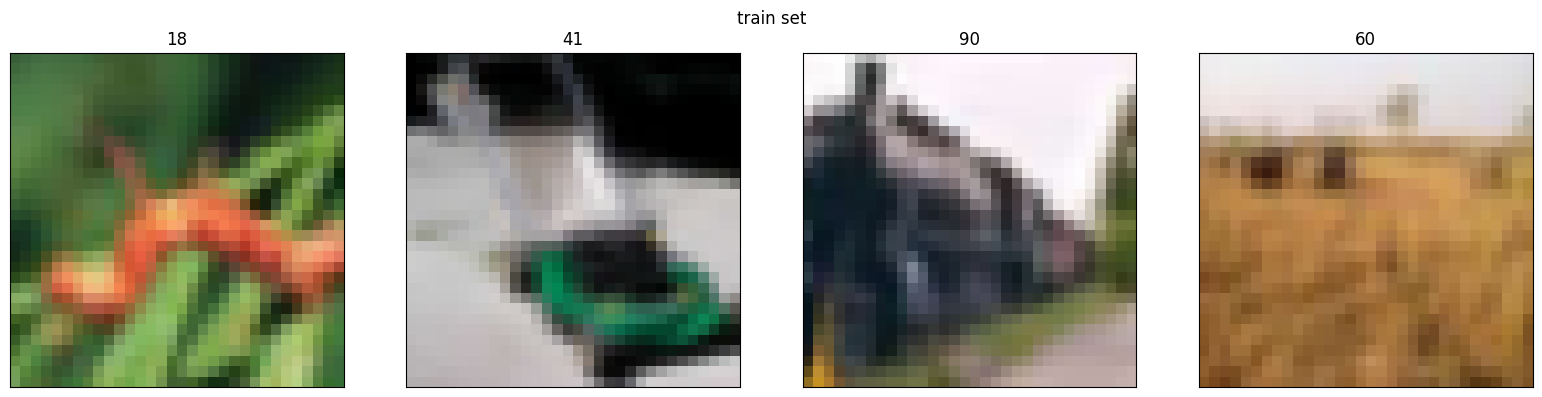

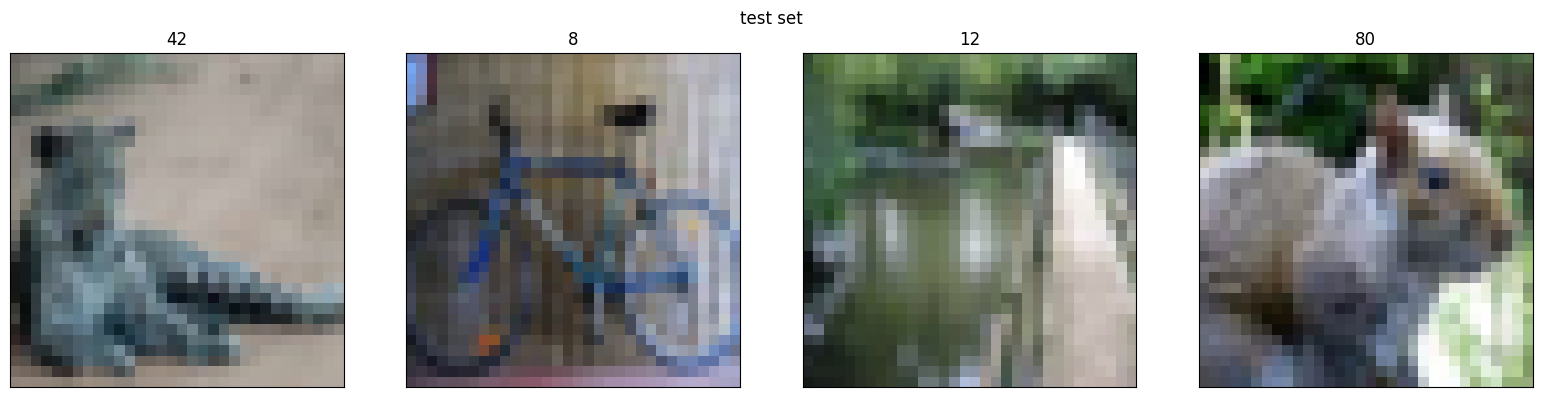

In [2]:
train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), # will transform pixel [0, 255] -> [0, 1]
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(
            size=(32, 32),
            scale=(0.8, 1.0),
            ratio=(0.75, 1.3333333333333333),
            interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # transform [0, 1] -> [-1, +1]
    ])
)


train_ratio = 0.85
val_ratio = 1.0 - train_ratio
num_train_samples = int(len(train_dataset) * train_ratio)
num_val_samples = len(train_dataset) - num_train_samples
train_dataset, val_dataset = random_split(train_dataset, [num_train_samples, num_val_samples])

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

import matplotlib.pyplot as plt
def show_image_samples(samples, nrows, ncols, title: str = "title"):
    fig = plt.figure(figsize=(16, 4))
    for i, (data, gdth) in enumerate(samples):
        ax = fig.add_subplot(nrows, ncols, i + 1, xticks=[], yticks=[])
        ax.set_title(f"{gdth}")

        image = data.numpy().transpose((1, 2, 0))  # 将图像维度从 (C, H, W) 转为 (H, W, C)
        image = (image * 0.5) + 0.5  # 反归一化

        ax.imshow(image)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

train_samples = [train_dataset[i] for i in \
           random.sample(range(len(train_dataset)), 4)]
test_samples = [test_dataset[i] for i in \
           random.sample(range(len(test_dataset)), 4)]

show_image_samples(train_samples, 1, 4, "train set")
show_image_samples(test_samples, 1, 4, "test set")

# Simplified ViT with Pytorch

In [ ]:
class PatchSpliter(nn.Module):
    def __init__(self,
        image_shape: tuple,
        patch_shape: tuple,
        in_channels: int,
        hd_channels: int
    ):
        super().__init__()
        assert isinstance(image_shape, tuple) and len(image_shape) == 2, \
        "wrong image shape"
        assert isinstance(patch_shape, tuple) and len(patch_shape) == 2, \
        "wrong patch shape"

        self.spliter = nn.Conv2d(
            in_channels=in_channels,
            out_channels=hd_channels,
            kernel_size=patch_shape,
            stride=patch_shape
        )

        image_shape = (
            round(image_shape[0] / patch_shape[0]) * patch_shape[0],
            round(image_shape[1] / patch_shape[1]) * patch_shape[1]
        )
        self.image_shape = image_shape
        self.patch_shape = patch_shape

        self.n_token = \
            (image_shape[0] // patch_shape[0]) * \
            (image_shape[1] // patch_shape[1])
    
    def forward(self, x: torch.Tensor):
        x = F.interpolate(x, self.image_shape, mode="bilinear", align_corners=False)
        x = self.spliter(x)
        x = x.flatten(start_dim=2).transpose(1, 2)
        return x

class PosEncoder(nn.Module):
    def __init__(self,
        n_token: int,
        d_token: int
    ):
        super().__init__()

        self.n_token = n_token
        self.d_token = d_token
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        # 可学习位置参数
        self.pos_addon = nn.Parameter(torch.randn(1, n_token + 1, d_token))
        # 固定位置参数
        pos_grid = torch.zeros(n_token, d_token)
        position = torch.arange(0, n_token, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_token, 2).float() * (-math.log(10000.0) / d_token))
        pos_grid[:, 0::2] = torch.sin(position * div_term) # even indices
        pos_grid[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        self.register_buffer("pos_grid", pos_grid)


    def forward(self, x: torch.Tensor):
        # add un-learnable position info
        B, S, E = x.size()
        assert S == self.n_token and E == self.d_token, \
            f"wrong sequence sample, get {x.size()[0:]}, expect n, {(self.n_token, self.d_token)}"
        x = x + self.pos_grid.unsqueeze(dim=0)

        # add cls_token
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_token, x], dim=1)

        # add learnable position info
        x = x + self.pos_addon
        x = F.dropout(x, p=2e-1)
        return x
    
class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="gelu", batch_first=True):
        super().__init__(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, 
                         dropout=dropout, activation=activation, batch_first=batch_first)
    
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # 显式调用 multihead attention 并返回注意力权重
        attn_output, attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                                  key_padding_mask=src_key_padding_mask,
                                                  need_weights=True)
        # 继续后续的前向传播逻辑
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return src, attn_weights

class ViTxTorch(nn.Module):
    def __init__(self,
        num_class: int,
        in_channels: int,
        hd_channels: int,
        image_shape: tuple,
        patch_shape: tuple,
        encoder_heads: int,
        encoder_layers: int
    ):
        super().__init__()

        self.spliter = PatchSpliter(
            image_shape=image_shape,
            patch_shape=patch_shape,
            in_channels=in_channels,
            hd_channels=hd_channels
        )
        self.posencd = PosEncoder(
            n_token=self.spliter.n_token,
            d_token=hd_channels
        )
        self.mhdencd = nn.TransformerEncoder(
            # 做CV的习惯批大小维度在第一维度
            nn.TransformerEncoderLayer(
                batch_first=True,
                d_model=hd_channels,
                dim_feedforward=4 * hd_channels,
                nhead=encoder_heads,
                dropout=2e-1,
                activation="gelu"
            ),
            num_layers=encoder_layers
        )

        self.outhead = nn.Linear(hd_channels, num_class)

    def forward(self, x: torch.Tensor):
        # image spliter
        x = self.spliter(x)
        x = self.posencd(x)
        x = self.mhdencd(x)
        x = self.outhead(x[:, 0, :])
        return x

In [ ]:
logger = utils.LoggerTXTFX("log", "ViTxTorch")

batch_size = 256
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2
)

lr = 1e-3
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_shape = (32, 32)
patch_shape = (4, 4)

model = ViTxTorch(
    num_class=100,
    in_channels=3,
    hd_channels=96,
    image_shape=image_shape,
    patch_shape=patch_shape,
    encoder_heads=8,
    encoder_layers=8
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.5,
    patience=25,
    verbose=True
)

def train(epoch: int):
    model.train()

    total_loss = 0.0
    total_accu = 0.0
    for iter, (data, gdth) in enumerate(train_dataloader):
        data = data.to(device)
        gdth = gdth.to(device)
        pred = model(data)

        optimizer.zero_grad()
        loss = loss_fn(pred, gdth)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = torch.argmax(pred, dim=1)
        accu = torch.sum(pred == gdth).item() / batch_size
        total_accu += accu

    return (
        total_loss / len(train_dataloader),
        total_accu / len(train_dataloader)
    )

def val(epoch: int):
    model.eval()

    total_loss = 0.0
    total_accu = 0.0
    with torch.no_grad():
        for iter, (data, gdth) in enumerate(val_dataloader):
            data = data.to(device)
            gdth = gdth.to(device)

            pred = model(data)
            loss = loss_fn(pred, gdth)

            total_loss += loss.item()
            pred = torch.argmax(pred, dim=1)
            accu = torch.sum(pred == gdth).item() / batch_size
            total_accu += accu
    
    return (
        total_loss / len(val_dataloader),
        total_accu / len(val_dataloader)
    )

def run():
    metrics = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_accu = train(epoch)
        val_loss, val_accu = val(epoch)
        
        metrics["train_loss"].append(train_loss)
        metrics["train_accu"].append(train_accu)
        metrics["val_loss"].append(val_loss)
        metrics["val_accu"].append(val_accu)
        logger.txt.info(
            f"[epoch {epoch + 1:3d}] " + \
            f"train loss: {train_loss:.3f}, " + \
            f"train accu: {train_accu:.3f}, " + \
            f"val loss: {val_loss:.3f}, " + \
            f"val accu: {val_accu:.3f}"
        )

        scheduler.step(val_loss)

In [5]:
run()

[2025-02-20 21:36:54|INFO] [epoch   1] train loss: 4.364, train accu: 0.035, val loss: 4.191, val accu: 0.047
[2025-02-20 21:37:03|INFO] [epoch   2] train loss: 4.044, train accu: 0.064, val loss: 3.945, val accu: 0.076
[2025-02-20 21:37:13|INFO] [epoch   3] train loss: 3.808, train accu: 0.102, val loss: 3.700, val accu: 0.113
[2025-02-20 21:37:22|INFO] [epoch   4] train loss: 3.641, train accu: 0.130, val loss: 3.564, val accu: 0.147
[2025-02-20 21:37:31|INFO] [epoch   5] train loss: 3.501, train accu: 0.153, val loss: 3.482, val accu: 0.161
[2025-02-20 21:37:40|INFO] [epoch   6] train loss: 3.377, train accu: 0.176, val loss: 3.265, val accu: 0.194
[2025-02-20 21:37:50|INFO] [epoch   7] train loss: 3.261, train accu: 0.199, val loss: 3.311, val accu: 0.197
[2025-02-20 21:37:59|INFO] [epoch   8] train loss: 3.204, train accu: 0.208, val loss: 3.426, val accu: 0.182
[2025-02-20 21:38:08|INFO] [epoch   9] train loss: 3.133, train accu: 0.226, val loss: 3.164, val accu: 0.212
[2025-02-2

Epoch 00059: reducing learning rate of group 0 to 5.0000e-04.


[2025-02-20 21:46:02|INFO] [epoch  60] train loss: 1.628, train accu: 0.536, val loss: 2.510, val accu: 0.398
[2025-02-20 21:46:12|INFO] [epoch  61] train loss: 1.555, train accu: 0.554, val loss: 2.513, val accu: 0.391
[2025-02-20 21:46:21|INFO] [epoch  62] train loss: 1.555, train accu: 0.552, val loss: 2.560, val accu: 0.392
[2025-02-20 21:46:30|INFO] [epoch  63] train loss: 1.510, train accu: 0.563, val loss: 2.566, val accu: 0.395
[2025-02-20 21:46:39|INFO] [epoch  64] train loss: 1.525, train accu: 0.561, val loss: 2.520, val accu: 0.398
[2025-02-20 21:46:49|INFO] [epoch  65] train loss: 1.470, train accu: 0.571, val loss: 2.568, val accu: 0.396
[2025-02-20 21:46:58|INFO] [epoch  66] train loss: 1.470, train accu: 0.574, val loss: 2.577, val accu: 0.401
[2025-02-20 21:47:07|INFO] [epoch  67] train loss: 1.491, train accu: 0.570, val loss: 2.557, val accu: 0.394
[2025-02-20 21:47:17|INFO] [epoch  68] train loss: 1.450, train accu: 0.578, val loss: 2.638, val accu: 0.385
[2025-02-2

Epoch 00086: reducing learning rate of group 0 to 2.5000e-04.


[2025-02-20 21:50:13|INFO] [epoch  87] train loss: 1.101, train accu: 0.665, val loss: 2.775, val accu: 0.400
[2025-02-20 21:50:23|INFO] [epoch  88] train loss: 1.075, train accu: 0.673, val loss: 2.749, val accu: 0.405
[2025-02-20 21:50:32|INFO] [epoch  89] train loss: 1.042, train accu: 0.684, val loss: 2.781, val accu: 0.400
[2025-02-20 21:50:41|INFO] [epoch  90] train loss: 1.050, train accu: 0.679, val loss: 2.800, val accu: 0.405
[2025-02-20 21:50:50|INFO] [epoch  91] train loss: 1.021, train accu: 0.689, val loss: 2.831, val accu: 0.399
[2025-02-20 21:51:00|INFO] [epoch  92] train loss: 1.009, train accu: 0.692, val loss: 2.822, val accu: 0.400
[2025-02-20 21:51:09|INFO] [epoch  93] train loss: 0.996, train accu: 0.696, val loss: 2.861, val accu: 0.400
[2025-02-20 21:51:18|INFO] [epoch  94] train loss: 0.991, train accu: 0.699, val loss: 2.867, val accu: 0.401
[2025-02-20 21:51:28|INFO] [epoch  95] train loss: 1.017, train accu: 0.687, val loss: 2.886, val accu: 0.399
[2025-02-2

In [6]:
def test():
    model.eval()

    total_loss = 0.0
    total_accu = 0.0
    with torch.no_grad():
        for iter, (data, gdth) in enumerate(test_dataloader):
            data = data.to(device)
            gdth = gdth.to(device)

            pred = model(data)
            loss = loss_fn(pred, gdth)

            total_loss += loss.item()
            pred = torch.argmax(pred, dim=1)
            accu = torch.sum(pred == gdth).item() / batch_size
            total_accu += accu
    
    return (
        total_loss / len(test_dataloader),
        total_accu / len(test_dataloader)
    )

test_loss, test_accu = test()
logger.txt.info(f"test loss: {test_loss:.3f}, test accu: {test_accu:.3f}")

[2025-02-20 21:52:15|INFO] test loss: 2.900, test accu: 0.412
